# SubgraphX on Cora dataset for 2-layer GCN

In [1]:
from dig.xgraph.dataset import SynGraphDataset
from dig.xgraph.models import *
import torch
from torch_geometric.data import DataLoader
from torch_geometric.data import Data, InMemoryDataset, download_url, extract_zip
import os.path as osp
import os
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
from dig.xgraph.method.subgraphx import PlotUtils
from dig.xgraph.method.subgraphx import find_closest_node_result
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Load dataset

In [2]:
#dataset = SynGraphDataset('./datasets', 'BA_shapes')
dataset_name = 'Cora'
path = "./datasets/Planetoid/"
dataset = Planetoid(path, dataset_name, transform=T.NormalizeFeatures())
#dataset.data.x = dataset.data.x.to(torch.float32)
#dataset.data.x = dataset.data.x[:, :1]
dim_node = dataset.num_node_features
dim_edge = dataset.num_edge_features
num_classes = dataset.num_classes

### Load model and checkpoints

In [3]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 128)
        self.conv2 = GCNConv(128, 128)
        self.fc = torch.nn.Linear(128, dataset.num_classes)
    
    def arguments_read(self, *args, **kwargs):

        data: Batch = kwargs.get('data') or None

        if not data:
            if not args:
                assert 'x' in kwargs
                assert 'edge_index' in kwargs
                x, edge_index = kwargs['x'], kwargs['edge_index'],
                batch = kwargs.get('batch')
                if batch is None:
                    batch = torch.zeros(kwargs['x'].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 2:
                x, edge_index = args[0], args[1]
                batch = torch.zeros(args[0].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 3:
                x, edge_index, batch = args[0], args[1], args[2]
            else:
                raise ValueError(f"forward's args should take 2 or 3 arguments but got {len(args)}")
        else:
            x, edge_index, batch = data.x, data.edge_index, data.batch

        return x, edge_index, batch

    # def forward(self, x, edge_index):
    def forward(self, *args, **kwargs):
        x, edge_index, batch = self.arguments_read(*args, **kwargs)
        
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def get_emb(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

model = Net().to(device)

In [4]:
data = dataset.data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [5]:
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    log_logits = model(data.x, data.edge_index)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    if epoch % 10 == 0:
        print(f"Epoch: {epoch:3d}, loss: {loss.item():.4f}")
    loss.backward()
    optimizer.step()

Epoch:  10, loss: 0.0109
Epoch:  20, loss: 0.0052
Epoch:  30, loss: 0.0014
Epoch:  40, loss: 0.0002
Epoch:  50, loss: 0.0010
Epoch:  60, loss: 0.0011
Epoch:  70, loss: 0.0061
Epoch:  80, loss: 0.0032
Epoch:  90, loss: 0.0026
Epoch: 100, loss: 0.0033
Epoch: 110, loss: 0.0037
Epoch: 120, loss: 0.0043
Epoch: 130, loss: 0.0034
Epoch: 140, loss: 0.0044
Epoch: 150, loss: 0.0031
Epoch: 160, loss: 0.0036
Epoch: 170, loss: 0.0034
Epoch: 180, loss: 0.0037
Epoch: 190, loss: 0.0042
Epoch: 200, loss: 0.0036


In [6]:
def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

print(f"Test accuracy: {test()*100:.2f}")

Test accuracy: 80.40


In [7]:
from dig.xgraph.method import SubgraphX
explainer = SubgraphX(model, num_classes=7, device=device,
                      explain_graph=False, reward_method='nc_mc_l_shapley')

### Default Visualization

explain graph node 50


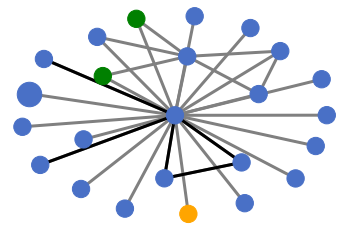

In [8]:
# --- Create data collector and explanation processor ---
from dig.xgraph.evaluation import XCollector
x_collector = XCollector()

index = -1
node_indices = torch.where(dataset[0].test_mask)[0].tolist()
data = dataset[0]

from dig.xgraph.method.subgraphx import PlotUtils
from dig.xgraph.method.subgraphx import find_closest_node_result

# Visualization
max_nodes = 5
node_idx = 50
print(f'explain graph node {node_idx}')
data.to(device)
logits = model(data.x, data.edge_index)
prediction = logits[node_idx].argmax(-1).item()

_, explanation_results, related_preds = \
    explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)

explanation_results = explanation_results[prediction]
explanation_results = explainer.read_from_MCTSInfo_list(explanation_results)

plotutils = PlotUtils(dataset_name='ba_shapes', is_show=True)
explainer.visualization(explanation_results,
                        max_nodes=max_nodes,
                        plot_utils=plotutils,
                        y=data.y)

### Customized Visualization

In [9]:
# --- Create data collector and explanation processor ---
from dig.xgraph.evaluation import XCollector
x_collector = XCollector()

index = -1
#node_indices = torch.where(dataset[0].test_mask * dataset[0].y != 0)[0].tolist()
#data = dataset[0]


# Visualization
max_nodes = 5
node_idx = 50 #node_indices[20]
print(f'explain graph node {node_idx}')
#data.to(device)
logits = model(data.x, data.edge_index)
prediction = logits[node_idx].argmax(-1).item()

_, explanation_results, related_preds = \
    explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)

explanation_results = explanation_results[prediction]
explanation_results = explainer.read_from_MCTSInfo_list(explanation_results)

tree_node_x = find_closest_node_result(explanation_results, max_nodes=max_nodes)

explain graph node 50


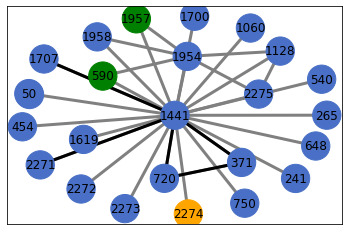

In [10]:
nodelist = tree_node_x.coalition
graph = tree_node_x.ori_graph

subset = explainer.mcts_state_map.subset
subgraph_y = data.y[subset].to('cpu')
subgraph_y = torch.tensor([subgraph_y[node].item() for node in tree_node_x.ori_graph.nodes()])

edgelist = [(n_frm, n_to) for (n_frm, n_to) in graph.edges()  if n_frm in nodelist and n_to in nodelist]



explainer_node_index = explainer.mcts_state_map.new_node_idx


node_idxs = {k: int(v) for k, v in enumerate(subgraph_y.reshape(-1).tolist())}
node_color = ['#FFA500', '#4970C6', '#FE0000', 'green']
colors = [node_color[v % len(node_color)] for k, v in node_idxs.items()]

import networkx as nx

pos = nx.kamada_kawai_layout(graph)  # calculate according to graph.nodes()
pos_nodelist = {k: v for k, v in pos.items() if k in nodelist}

nx.draw_networkx_nodes(graph, pos,
                       nodelist=list(graph.nodes()),
                       node_color=colors,
                       node_size=800)
if isinstance(colors, list):
    list_indices = int(np.where(np.array(graph.nodes()) == explainer_node_index)[0])
    node_idx_color = colors[list_indices]
else:
    node_idx_color = colors

nx.draw_networkx_nodes(graph, pos=pos,
                       nodelist=[explainer_node_index],
                       node_color=node_idx_color,
                       node_size=800)

edge_color='gray'
subgraph_edge_color='black'
nx.draw_networkx_edges(graph, pos, width=3, edge_color=edge_color, arrows=False)

nx.draw_networkx_edges(graph, pos=pos_nodelist,
                       edgelist=edgelist, width=3,
                       edge_color=subgraph_edge_color,
                       arrows=False)

org_node_ids = subset.cpu().numpy()
node_labels = {i: org_node_ids[i] for i in graph.nodes} # {node_id: org_node_ids[ind] for ind, node_id in enumerate(list(graph.nodes))}
nx.draw_networkx_labels(graph, pos, node_labels)
plt.show()

### The metric result

I didn't run the following code since it takes a lot of time!!!

In [11]:
# node_indices = torch.where(data.test_mask)[0].tolist()
# max_nodes = 5
# for node_idx in node_indices:
#     index += 1
#     print(f'explain graph node {node_idx}')
#     data.to(device)

#     if torch.isnan(data.y[0].squeeze()):
#         continue

#     logits = model(data.x, data.edge_index)
#     prediction = logits[node_idx].argmax(-1).item()

#     _, explanation_results, related_preds = \
#         explainer(data.x, data.edge_index, node_idx=node_idx, max_nodes=max_nodes)

#     explanation_results = explanation_results[prediction]
#     explanation_results = explainer.read_from_MCTSInfo_list(explanation_results)
#     result = find_closest_node_result(explanation_results, max_nodes=max_nodes)

#     x_collector.collect_data(result.coalition, related_preds, label=prediction)
#     if index >= 20:
#         break

# print(f'Fidelity: {x_collector.fidelity:.4f}\n',
#       f'Infidelity: {x_collector.fidelity_inv:.4f}\n'
#       f'Sparsity: {x_collector.sparsity:.4f}')